In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils,datasets
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

In [2]:
train_data_dir = 'D:/HDD_downloads/Facial Expression Database/3_SFEW/Set1'
test_data_dir = 'D:/HDD_downloads/Facial Expression Database/3_SFEW/Set2'

train_transforms = transforms.Compose([
                                #transforms.Grayscale(num_output_channels=1),
                                #transforms.Resize((100,100)),
                                #transforms.RandomCrop((48,48)),
                                transforms.ColorJitter(brightness=0.5),
                                #transforms.RandomRotation(degrees=45),
                                transforms.RandomHorizontalFlip(p=0.5),
                                #transforms.RandomVerticalFlip(p=0.05),
                                #transforms.RandomGrayscale(p=0.2),
                                transforms.Resize(size = (48,48)),
                                #transforms.Resize(size = (227,227)),
                                transforms.ToTensor()])
                                #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
                                #transforms.Grayscale(num_output_channels=1),
                                transforms.ColorJitter(brightness=0.5),
                                #transforms.RandomRotation(degrees=45),
                                transforms.RandomHorizontalFlip(p=0.5),
                                #transforms.RandomVerticalFlip(p=0.05),
                                #transforms.RandomGrayscale(p=0.2),
                                #transforms.Resize(size = (227,227)),
                                transforms.Resize(size = (48,48)),
                                transforms.ToTensor()])
                                #transforms.Normalize((0.5), (0.5))])


train_data = datasets.ImageFolder(root=train_data_dir, transform=train_transforms)                                       
test_data = datasets.ImageFolder(root=test_data_dir , transform=test_transforms)


random_seed = 42
torch.manual_seed(random_seed)

batch_num = 35     #50

trainloader = DataLoader(train_data, batch_num, shuffle=True, num_workers=4, pin_memory=True)
testloader = DataLoader(test_data, batch_num*2, num_workers=4, pin_memory=True)

23


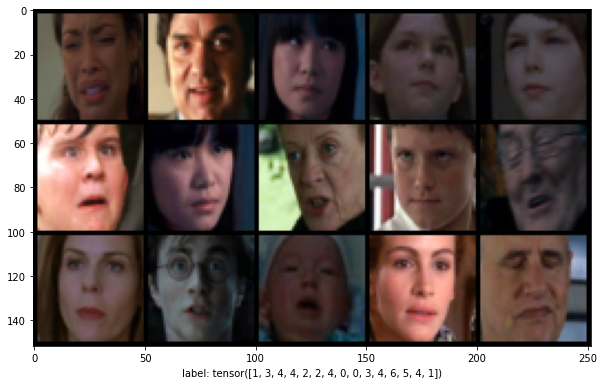

In [3]:
def showImages(dataset):
    loader = DataLoader(dataset,batch_size=15,shuffle=True)
    print(len(loader))
    batch = next(iter(loader))
    images , labels= batch    #labels corresponds to the ith folder from where the image is picked
    grid = utils.make_grid(images,nrow=5)
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(grid,(1,2,0)))  #to convert the dimentions from [width,height,channels] to [height,channels,width] then transpose
    plt.xlabel(f'label: {labels}')
    
showImages(train_data)

In [15]:
###  The Accuracy calculating function...................
from sklearn.metrics import confusion_matrix

predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    global predlist
    global lbllist
    predlist=torch.cat([predlist,preds.view(-1)])
    lbllist=torch.cat([lbllist,labels.view(-1)])
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [16]:
class FERBase(nn.Module):
    
    # this takes is batch from training dl
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                     # calls the forward().  calls the training model and generates predictions
        loss = F.cross_entropy(out, labels)    # calculates loss compare to real labels using cross entropy
        acc = accuracy(out, labels)
        return loss,acc
    
    # this takes in batch from validation dl
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)    #calls the forward()
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)            # calls the accuracy function to measure the accuracy
        #print("batch size ,ggg acc shape=",len(batch),acc)
        return {'val_loss': loss.detach(), 'val_acc': acc}   #there are gradients associated with the loss in PyTorch which are used while training neural network model. So, while displaying the loss we don’t need this gradient and hence, .detach() method.

    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()    # finds out the mean loss of the epoch batch
        
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()       # finds out the mean acc of the epoch batch
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}  # .item() just converts tensor to python object
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, train_acc: {:.4f}%, val_loss: {:.4f}, test_acc: {:.4f}%".format(
            epoch, result['lrs'][-1], result['train_loss'], result['train_acc']*100, result['val_loss'], result['val_acc']*100))

# Resnet9 structure

In [17]:
def conv_block(in_chnl, out_chnl, pool=False):
    layers = [
        nn.Conv2d(in_chnl, out_chnl, kernel_size=3, stride=1, padding=1, dilation=1, groups=1),
        nn.BatchNorm2d(out_chnl),
        nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2,2))   #filter=2x2  stride=2
        
    return nn.Sequential(*layers)   #if the operation sequence is not defined inside the sequential() itself, then *layers is used

class FERModel(FERBase):
    def __init__(self, in_chnls, num_cls):
        super().__init__()
        
        self.conv1 = conv_block(in_chnls, 64, pool=True)           # 64x24x24 
        self.conv2 = conv_block(64, 128, pool=True)                # 128x12x12
        self.resnet1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))    # Resnet layer 1: includes 2 conv2d
        
        self.conv3 = conv_block(128, 256, pool=True)       # 256x6x6 
        self.conv4 = conv_block(256, 512, pool=True)       # 512x3x3
        
        self.resnet2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))    # Resnet layer 2: includes 2 conv2d
        self.convTemp = conv_block(512,512)
        self.classifier = nn.Sequential(nn.MaxPool2d(3,2),
                                        nn.Flatten(),
                                        nn.Linear(512,256),
                                        
                                        nn.Linear(256,256),
                                        nn.Linear(256,256),
                                        nn.Linear(256,256),
                                        nn.Linear(256,256),
                                        nn.Linear(256,256),
                                        nn.Linear(256,256),
                                        
                                        nn.Linear(256,84),
                                        nn.Linear(84, num_cls))   
        
   #.///////////////////////////////////////////////////////////////////////////////////////     
         # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(640, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
         # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        #print("1. after localisation size=",xs.shape)
        xs = xs.view(-1, 640)
        #print("2. after localisation size=",xs.shape)  #1,3200
        theta = self.fc_loc(xs)
        #print("before theta size=",theta.shape)  #1,6
        theta = theta.view(-1,2,3)
        #print("after theta size=",theta.shape) 
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        
        return x
        
    #/////////////////////////////////////////////////////////////////////////////////////
        
        
    def forward(self,xb):
        #out = self.stn(xb)
        #print("after localisation size=",out.shape)
        out = self.conv1(xb)
        #print("after conv1 size=",out.shape)
        out = self.conv2(out)
        #print("after conv2 size=",out.shape)
        out = self.resnet1(out) + out   #output from previous operation is added directly to this layer 
        #print("after resnet1 size=",out.shape)
        
        out = self.conv3(out)
        #print("after conv3 size=",out.shape)
        out = self.conv4(out)
        
        out = self.convTemp(out)
        out = self.convTemp(out)
        out = self.convTemp(out)
        out = self.convTemp(out)
        #print("after conv4 size=",out.shape)
        out = self.resnet2(out) + out
        
        out = self.resnet2(out) + out
        #print("after resnet2 size=",out.shape)
        out = self.classifier(out)
        #print("after classifier size=",out.shape)
        return out
    
### create object of the model........................     
model = FERModel(3, 7)


# Alexnet structure

In [7]:
'''
class FERModel(FERBase):
    def __init__(self, in_chnls, num_cls):
        super(FERModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 11, stride=4, padding=0 ) #to get 55x55x96
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2) #to get 27x27x96
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 2) #to get 27x27x256
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1) 
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1  = nn.Linear(in_features= 9216, out_features= 4096)
        self.fc2  = nn.Linear(in_features= 4096, out_features= 4096)
        self.fc3 = nn.Linear(in_features=4096 , out_features=7)
        
    def forward(self,xb):
        out = self.conv1(xb)
        #print("after conv1 size=",out.shape)
        out = self.maxpool(out)
        out = self.conv2(out)
        out = self.maxpool(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.maxpool(out)
        out = out.reshape(out.shape[0], -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc2(out))
        
        out = self.fc3(out)
        return out
    
### create object of the model........................     
model = FERModel(3, 7)
'''

'\nclass FERModel(FERBase):\n    def __init__(self, in_chnls, num_cls):\n        super(FERModel, self).__init__()\n        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 11, stride=4, padding=0 ) #to get 55x55x96\n        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2) #to get 27x27x96\n        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 2) #to get 27x27x256\n        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1) \n        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)\n        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)\n        self.fc1  = nn.Linear(in_features= 9216, out_features= 4096)\n        self.fc2  = nn.Linear(in_features= 4096, out_features= 4096)\n        self.fc3 = nn.Linear(in_features=4096 , out_features=7)\n        \n    def forward(self,xb):\n        o

shape of image:  torch.Size([35, 3, 48, 48])
shape of output:  torch.Size([35, 7])


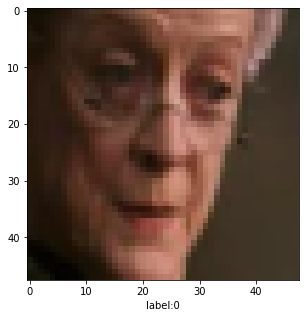

In [8]:
for batch in trainloader:
    images,lbl=batch
    print('shape of image: ', images.shape)
    out = model(images)
    print('shape of output: ', out.shape)   #should return 20 , 7 length lists showing probability for each class
    grid = utils.make_grid(images[0],nrow=1)
    plt.figure(figsize=(5,5))
    plt.imshow(np.transpose(grid,(1,2,0)))
    plt.xlabel(f'label:{lbl[0]}')
    break

In [18]:
@torch.no_grad()    # this is for stopping the model from keeping track ofold parameters
def evaluate(model, testloader):
    # This function will evaluate the model and give back the val acc and loss
    model.eval()  #turns off droput and batchnorm layers, since they are not required during validation
    outputs = [model.validation_step(batch) for batch in testloader]
    #print("output0 and outputs shape in fun evaluate=",outputs[0],len(outputs))
    return model.validation_epoch_end(outputs)

# getting the current learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# this fit function follows the intuition of 1cycle lr
def fit(epochs, max_lr, model, train_loader=trainloader, testloader=testloader, weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []    #keep track of the evaluation results
    
    # setting upcustom optimizer including weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # setting up 1cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(trainloader))
    #sched = torch.optim.SGD(model.parameters(), max_lr, momentum=0.9)
    
    for epoch in range(epochs):
        # training
        model.train()
        train_losses = []
        train_acc = []
        lrs = []
        for batch in trainloader:
            loss,acc = model.training_step(batch)
            train_losses.append(loss)
            train_acc.append(acc)
            loss.backward()
            
            # gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()    #every torch.optim class emplements the step() which updates the parameters
            optimizer.zero_grad()  #Sets the gradients of all optimized torch.Tensors to zero
            
            # record the lr
            lrs.append(get_lr(optimizer))
            sched.step()
            
        #validation
        result = evaluate(model, testloader)
        #result = evaluate(model, trainloader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_acc).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [19]:
evaluate(model, testloader)

{'val_loss': 1.953147053718567, 'val_acc': 0.1190476194024086}

In [20]:
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4

In [21]:
%%time
print("working on it, please wait")
history = fit(100, max_lr, model, weight_decay=weight_decay, grad_clip=grad_clip)

working on it, please wait
Epoch [0], last_lr: 0.00004, train_loss: 1.9471, train_acc: 15.0000%, val_loss: 1.9516, test_acc: 12.3810%
Epoch [1], last_lr: 0.00005, train_loss: 1.9304, train_acc: 18.8571%, val_loss: 1.9525, test_acc: 13.0952%
Epoch [2], last_lr: 0.00006, train_loss: 1.9049, train_acc: 24.0952%, val_loss: 1.9588, test_acc: 13.0952%
Epoch [3], last_lr: 0.00008, train_loss: 1.8521, train_acc: 23.6667%, val_loss: 1.9879, test_acc: 13.0952%
Epoch [4], last_lr: 0.00010, train_loss: 1.7526, train_acc: 26.1429%, val_loss: 1.9956, test_acc: 15.9524%
Epoch [5], last_lr: 0.00013, train_loss: 1.7012, train_acc: 31.1905%, val_loss: 2.0267, test_acc: 14.2857%
Epoch [6], last_lr: 0.00016, train_loss: 1.5567, train_acc: 38.4762%, val_loss: 2.0386, test_acc: 19.4048%
Epoch [7], last_lr: 0.00020, train_loss: 1.4130, train_acc: 43.1905%, val_loss: 2.1453, test_acc: 15.4762%
Epoch [8], last_lr: 0.00024, train_loss: 1.3986, train_acc: 45.8095%, val_loss: 2.8533, test_acc: 14.0476%
Epoch [9],

Epoch [76], last_lr: 0.00024, train_loss: 0.0093, train_acc: 99.7143%, val_loss: 4.1603, test_acc: 32.7381%
Epoch [77], last_lr: 0.00022, train_loss: 0.0042, train_acc: 100.0000%, val_loss: 4.4375, test_acc: 25.1191%
Epoch [78], last_lr: 0.00021, train_loss: 0.0019, train_acc: 100.0000%, val_loss: 4.6389, test_acc: 24.1667%
Epoch [79], last_lr: 0.00019, train_loss: 0.0053, train_acc: 99.7143%, val_loss: 4.5092, test_acc: 34.1667%
Epoch [80], last_lr: 0.00017, train_loss: 0.0012, train_acc: 100.0000%, val_loss: 4.6317, test_acc: 24.8810%
Epoch [81], last_lr: 0.00015, train_loss: 0.0011, train_acc: 100.0000%, val_loss: 4.6295, test_acc: 29.2857%
Epoch [82], last_lr: 0.00014, train_loss: 0.0009, train_acc: 100.0000%, val_loss: 4.8721, test_acc: 26.5476%
Epoch [83], last_lr: 0.00012, train_loss: 0.0025, train_acc: 100.0000%, val_loss: 4.7506, test_acc: 33.9286%
Epoch [84], last_lr: 0.00011, train_loss: 0.0004, train_acc: 100.0000%, val_loss: 5.0609, test_acc: 20.2381%
Epoch [85], last_lr: 

In [13]:
i = torch.randn(50,512,2,2)
m=nn.Flatten()
o = m(i)
o.shape

torch.Size([50, 2048])

The confusion Matrix:
[[6103  794  237  802 1279  994  946]
 [ 887 4142  176  241 1915  651  529]
 [ 808  543 4515  709 1460  595 1321]
 [1603  878  178 6607 1093  429  671]
 [1272 1303  316  449 5089 1286  337]
 [1638  598  397  511 1888 4389  529]
 [ 750  850  407  545 1142  298 5154]]


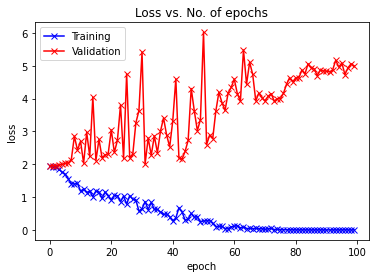

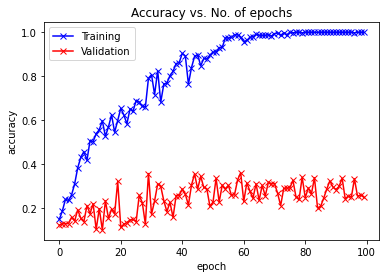

In [23]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_accuracy(history):
    train_losses = [x.get('train_acc') for x in history]
    val_losses = [x['val_acc'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
    
plot_losses(history)
plt.figure()
plot_accuracy(history)
#plot_lrs(history)

conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print("The confusion Matrix:")
print(conf_mat)